<center><h1>A comparative study of various Optimization Algorithms in<br> Deep Neural Network</h1></center> <center><h3>(Experimented on Churn Dataset)</h3></center> 

Dataset and description source : kaggle

## 1. Introduction

We aim to accomplist the following for this study:

i) Identify and visualize which factors contribute to customer churn/attrition:

ii) Build a prediction model that will perform the following:

Classify if a customer is going to churn or not and preferably and based on model performance, choose a model that will attach a probability to the churn to make it easier for customer service to target low hanging fruits in their efforts to prevent churn.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# To initiate the project at first change the current directory to our project directory.
%cd /content/drive/MyDrive/OPTAL  

/content/drive/MyDrive/OPTAL


## 2. Data set review & preparation
In this section we will seek to explore the structure of our data:

i) To understand the input space the data set</br>
ii) And to prepare the sets for exploratory and prediction tasks as described in section 1


In [ ]:
## REQUIRED LIBRARIES

# For data wrangling 

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#for model training

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# For visualization

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# Read the data frame
df = pd.read_csv('Churn_Modelling.csv', delimiter=',')
print(df.shape)
df.head(4)

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0


The Df has 1000 rows with 14 attributes. We review this further to identify what attributes will be necessary and what data manipulation needs to be carried out before Exploratory analysis and prediction modelling

In [ ]:
# Check columns list and missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Well our data is very detailed; no missing values!

In [ ]:
# Get unique count for each variable
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

From the above, we will not require the first 2 attributes as the are specific to a customer. It is borderline with the surname as this would result to profiling so we exclude this as well.

In [ ]:
# Drop the columns as explained above
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)


In [ ]:
# Review the top rows of what is left of the data frame
df.head(4)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0


From the above, a couple of question linger:

1. The data appears to be a snapshot as some point in time e.g. the balance is for a given date which leaves a lot of questions:
What date is it and of what relevance is this date
Would it be possible to obtain balances over a period of time as opposed to a single date.
2. There are customers who have exited but still have a balance in their account! What would this mean? Could they have exited from a product and not the bank?
3. What does being an active member mean and are there difference degrees to it? Could it be better to provide transaction count both in terms of credits and debits to the account instead?
4. A break down to the products bought into by a customer could provide more information topping listing of product count.

For this exercise, we proceed to model without context even though typically having context and better understanding of the data extraction process would give better insight and possibly lead to better and contextual results of the modelling process



In [ ]:
# Check variable data types
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 3. Exploratory Data Analysis

Here our main interest is to get an understanding as to how the given attributes relate too the 'Exit' status.

So we moslty have categorical variables and 5 continuous variables

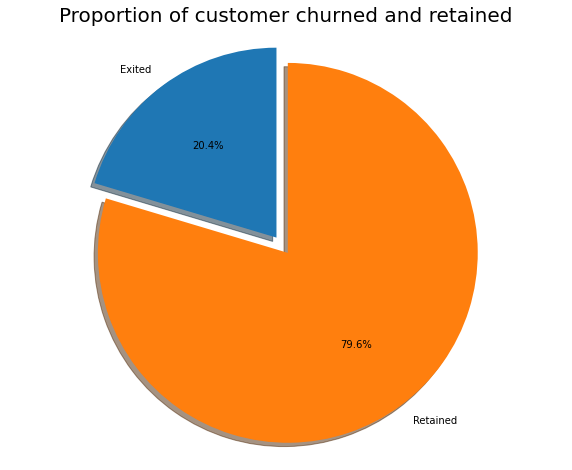

In [ ]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

So about 20% of the customers have churned. So the baseline model could be to predict that 20% of the customers will churn. Given 20% is a small number, we need to ensure that the chosen model does predict with great accuracy this 20% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained.

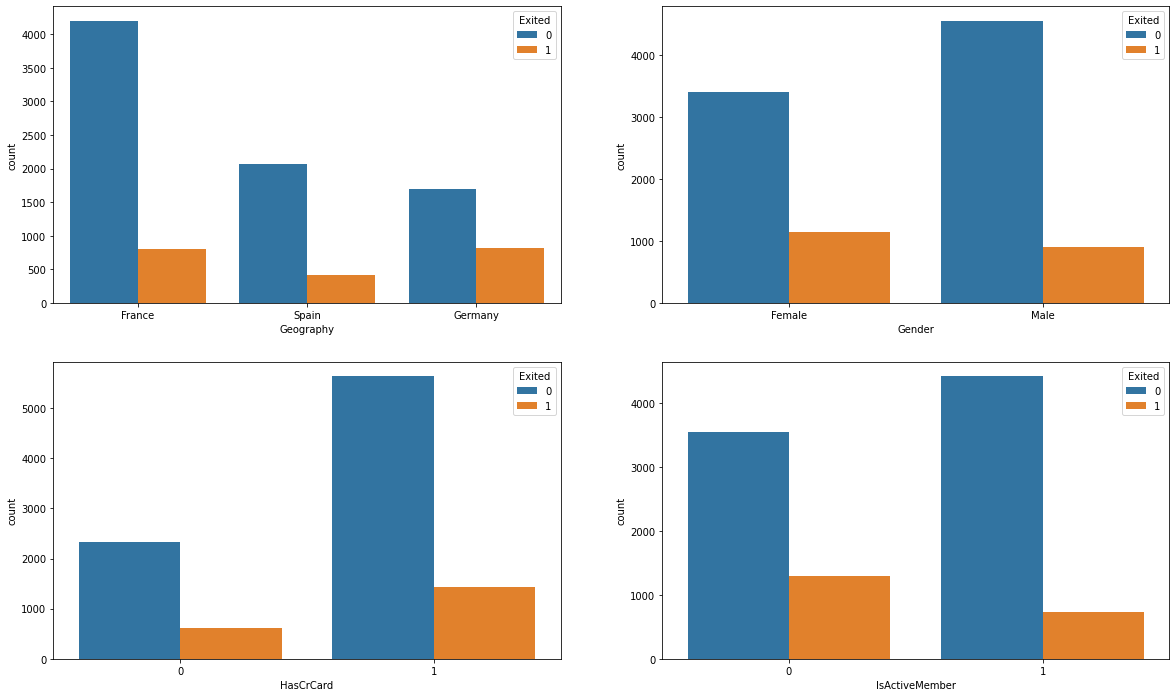

In [ ]:
# We first review the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

We note the following:

i) Majority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.</br>
ii) The proportion of female customers churning is also greater than that of male customers</br>
iii) Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.</br>
iv) Unsurprisingly the inactive members have a greater churn. Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn.

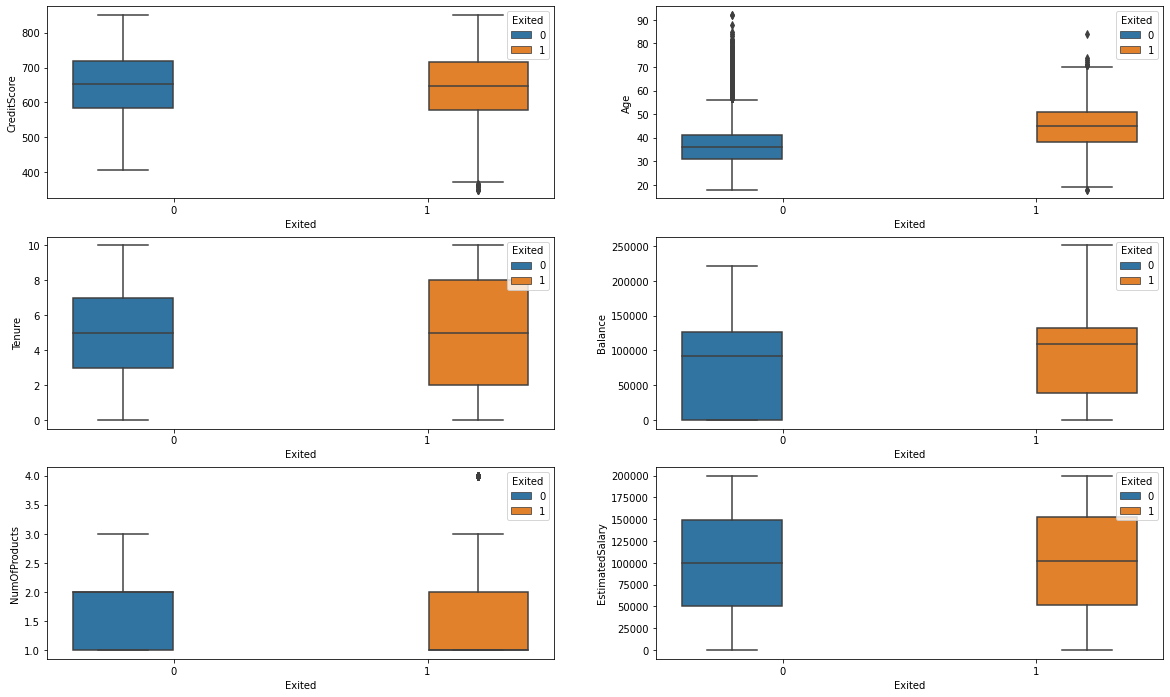

In [ ]:
 # Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

We note the following:

i) There is no significant difference in the credit score distribution between retained and churned customers.</br>
ii) The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups</br>
iii) With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure.</br>
iv) Worryingly, the bank is losing customers with significant bank balances which is likely to hit their available capital for lending.</br>
v) Neither the product nor the salary has a significant effect on the likelihood to churn.

### 4. Feature engineering

We seek to add features that are likely to have an impact on the probability of churning. We first split the train and test sets

In [ ]:
# Split Train, test data
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

8000
2000


In [ ]:
df_train['BalanceSalaryRatio'] = df_train.Balance/df_train.EstimatedSalary
df_train['CreditScoreGivenAge'] = df_train.CreditScore/(df_train.Age)
df_train['TenureByAge'] = df_train.Tenure/(df_train.Age)

In [ ]:
# Resulting Data Frame
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,CreditScoreGivenAge,TenureByAge
8159,461,Spain,Female,25,6,0.00,2,1,1,15306.29,0,0.000000,18.440000,0.240000
6332,619,France,Female,35,4,90413.12,1,1,1,20555.21,0,4.398550,17.685714,0.114286
8895,699,France,Female,40,8,122038.34,1,1,0,102085.35,0,1.195454,17.475000,0.200000
5351,558,Germany,Male,41,2,124227.14,1,1,1,111184.67,0,1.117305,13.609756,0.048780
4314,638,France,Male,34,5,133501.36,1,0,1,155643.04,0,0.857741,18.764706,0.147059


### 5. Data prep for model fitting

In [ ]:
# Arrange columns by data type for easier manipulation

continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df_train = df_train[['Exited'] + continuous_vars + cat_vars]
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,0,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,0,1,France,Male


For the one hot variables, we change 0 to -1 so that the models can capture a negative relation 
where the attribute in inapplicable instead of 0

In [ ]:
df_train.loc[df_train.HasCrCard == 0, 'HasCrCard'] = -1
df_train.loc[df_train.IsActiveMember == 0, 'IsActiveMember'] = -1
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,France,Male


In [ ]:
# One hot encode the categorical variables
lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    if (df_train[i].dtype == np.str or df_train[i].dtype == np.object):
        for j in df_train[i].unique():
            df_train[i+'_'+j] = np.where(df_train[i] == j,1,-1)
        remove.append(i)
df_train = df_train.drop(remove, axis=1)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,1,-1,-1,1,-1
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,-1,1,-1,1,-1
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,-1,1,-1,1,-1
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,-1,-1,1,-1,1
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,-1,1,-1,-1,1


In [ ]:
# minMax scaling the continuous variables
minVec = df_train[continuous_vars].min().copy()
maxVec = df_train[continuous_vars].max().copy()
df_train[continuous_vars] = (df_train[continuous_vars]-minVec)/(maxVec-minVec)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,0.222,0.094595,0.6,0.000000,0.333333,0.076118,0.000000,0.432000,0.323157,1,1,1,-1,-1,1,-1
6332,0,0.538,0.229730,0.4,0.360358,0.000000,0.102376,0.003317,0.205714,0.305211,1,1,-1,1,-1,1,-1
8895,0,0.698,0.297297,0.8,0.486406,0.000000,0.510225,0.000901,0.360000,0.300198,1,-1,-1,1,-1,1,-1
5351,0,0.416,0.310811,0.2,0.495130,0.000000,0.555744,0.000843,0.087805,0.208238,1,1,-1,-1,1,-1,1
4314,0,0.576,0.216216,0.5,0.532094,0.000000,0.778145,0.000647,0.264706,0.330882,-1,1,-1,1,-1,-1,1


In [ ]:
# data prep pipeline for test data
def DfPrepPipeline(df_predict,df_train_Cols,minVec,maxVec):
    # Add new features
    df_predict['BalanceSalaryRatio'] = df_predict.Balance/df_predict.EstimatedSalary
    df_predict['TenureByAge'] = df_predict.Tenure/(df_predict.Age - 18)
    df_predict['CreditScoreGivenAge'] = df_predict.CreditScore/(df_predict.Age - 18)
    # Reorder the columns
    continuous_vars = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
    cat_vars = ['HasCrCard','IsActiveMember',"Geography", "Gender"] 
    df_predict = df_predict[['Exited'] + continuous_vars + cat_vars]
    # Change the 0 in categorical variables to -1
    df_predict.loc[df_predict.HasCrCard == 0, 'HasCrCard'] = -1
    df_predict.loc[df_predict.IsActiveMember == 0, 'IsActiveMember'] = -1
    # One hot encode the categorical variables
    lst = ["Geography", "Gender"]
    remove = list()
    for i in lst:
        for j in df_predict[i].unique():
            df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
        remove.append(i)
    df_predict = df_predict.drop(remove, axis=1)
    # Ensure that all one hot encoded variables that appear in the train data appear in the subsequent data
    L = list(set(df_train_Cols) - set(df_predict.columns))
    for l in L:
        df_predict[str(l)] = -1        
    # MinMax scaling coontinuous variables based on min and max from the train data
    df_predict[continuous_vars] = (df_predict[continuous_vars]-minVec)/(maxVec-minVec)
    # Ensure that The variables are ordered in the same way as was ordered in the train set
    df_predict = df_predict[df_train_Cols]
    return df_predict

df_test = DfPrepPipeline(df_test,df_train.columns,minVec,maxVec)
df_test = df_test.mask(np.isinf(df_test))
df_test = df_test.dropna()
df_test.shape

(1996, 17)

## 6. Test-train-validation split

In [ ]:
# extract numpy arrays of test train data
x_train = df_train.iloc[:,1:].values
y_train = df_train.iloc[:,0].values
X_test = df_test.iloc[:,1:].values
Y_test = df_test.iloc[:,0].values

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.3)
print(X_train.shape, X_val.shape,X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(5600, 16) (2400, 16) (1996, 16) (5600,) (2400,) (1996,)


### 6. Model fitting and selection for best optimizer

For the model fitting, I try out the Artificial Neural Network with different optimizers and different learning rates.</br>


In [ ]:
# write your own network

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(16, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x

Mainly I used three types of learning rates:<br>
i) low </br>


In [ ]:
low_lr = 10**(-5)

ii) moderate </br>


In [ ]:
mod_lr = 10**(-3)

iii) high </br>


In [ ]:
high_lr = 0.1

iii) Adagrad <br>

Adagrad scales the step size for each parameter according to the history of gradients for that parameter which is basically done by dividing current gradient in update rule by the sum of previous gradients:
$$G_{k} = G_{k−1} + ∆f(x_{k})^{2} ;\;\;\; x_{k+1} = x_{k} − \frac{t}{\sqrt{G_{k} + ε}}∆f(x_{k})$$

where G is the accumulation of the history gradients, and ε is a smoothing term that avoids division by
zero (can be 1e − 6). The step size is different for each of the parameters. It is greater for parameters
where the historical gradients were small (since G is small) and the rate is small whenever historical
gradients were relatively big. Therefore, we need not to manually tune the step size t. We can use
a default value of 0.01. But when accumulation G becomes larger, the step size will reach zero at
infinity. So the following methods are proposed.


iv) RMSprop <br>

RMSprop is proposed to tackle the problem of step size vanishing of Adagrad. It employs the decaying average of the history gradients:

$$E[∆f(x)^{2}]_{k} = ρE[∆f(x)^{2}]_{k−1} + (1 − ρ)∆f(x_{k})^{2} $$
$$x_{k+1} = x_{k} − \frac{t}{\sqrt{E[∆f(x)2]_{k} + ε}}∆f(x_{k})$$

where ρ is a decay constant (e.g., 0.9).

v) Adam <br>

Adam optimization algorithm is an extension to stochastic gradient descent. It was presented in 2015.The name **Adam** is derived from **Adaptive moment estimation**.The authors describe Adam as combining the advantages of two other extensions of stochastic gradient descent algorithm.

Adam is another method that computes adaptive step size for each parameter. It uses both the decaying average of history gradients and their squared values. Adam update rule consists of the
following steps:

$$m_{k} = β_{1}m_{k−1} + (1 − β_{1})∆f(x_{k})$$
$$v_{k} = β_{2}v_{k−1} + (1 − β_{2})∆f(x_{k})^{2}$$
$$mˆ_{k} = \frac{m_{k}}{1 − β_{k}^{1}} ;\;\; vˆ_{k} = \frac{v_{k}}{1 − β_{k}^{2}}$$
$$x_{k+1} = x_{k} − \frac{t}{\sqrt{vˆ_{k} + ε}}mˆ_{k}$$

where β1 can be 0.9, β2 can be 0.999, and ε can be 1e − 8.

Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).



Now the training part :

In [ ]:
def train_network(optim = 'SGD',learning_rate = mod_lr,loss = nn.CrossEntropyLoss(),seed = 0,num_epochs = 100,batch_size = 50,X_train = X_train, Y_train = Y_train,X_val = X_val,Y_val = Y_val):
    from sklearn.utils import shuffle
    from torch.autograd import Variable

    # Loss function and optimizers
    
    net = Net()
    lr = learning_rate 
    criterion = loss

    if optim == 'SGD with momentum':
        optimizer = torch.optim.SGD(net.parameters(),lr = lr,momentum = 0.9)
    elif optim == 'Adagrad':
        optimizer = torch.optim.Adagrad(net.parameters(),lr = lr)
    elif optim == 'RMSprop':
        optimizer = torch.optim.RMSprop(net.parameters(),lr = lr)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(),lr = lr)
    else:
        optimizer = torch.optim.SGD(net.parameters(),lr = lr)   
    

    # Fix the hyper parameters

    batch_size = batch_size
    num_epochs = num_epochs
    batch_no = len(X_train) // batch_size
    batch_no_val = len(X_val) // batch_size

    bias_grads1 = []
    weight_grads1 = []
    bias_grads2 = []
    weight_grads2 = []
    T_Loss = []
    T_Acc = []
    V_Loss = []
    V_Acc = []

    torch.manual_seed(seed)

    for epoch in range(num_epochs):
      
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        samples = 0
        samples_ = 0

        X_train, Y_train = shuffle(X_train, Y_train)
        # Mini batch learning
        net.train()
        for i in range(batch_no):
            start = i * batch_size
            end = start + batch_size
            x_var = Variable(torch.FloatTensor(X_train[start:end]))
            y_var = Variable(torch.LongTensor(Y_train[start:end]))
            
            ypred_var = net(x_var)
            loss = criterion(ypred_var, y_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()*y_var.size(0)

            weight_grads1.append(np.linalg.norm(net.fc1.weight.grad.cpu().numpy()))
            bias_grads1.append(np.linalg.norm(net.fc1.bias.grad.cpu().numpy()))
            weight_grads2.append(np.linalg.norm(net.fc2.weight.grad.cpu().numpy()))
            bias_grads2.append(np.linalg.norm(net.fc2.bias.grad.cpu().numpy()))

            values, labels = torch.max(ypred_var, 1)
            num_right = np.sum(labels.data.numpy() == Y_train[start:end])
            train_acc += num_right
            samples += y_var.size(0)

        T_Loss.append(train_loss/samples)
        T_Acc.append(train_acc/samples)

        # Evaluate the model
        net.eval()
        with torch.no_grad():
            X_val, Y_val = shuffle(X_val, Y_val)
            
            # Mini batch validation
            for i in range(batch_no_val):
                start = i * batch_size
                end = start + batch_size
                x_val_var = Variable(torch.FloatTensor(X_val[start:end]))
                y_val_var = Variable(torch.LongTensor(Y_val[start:end]))

                ypred_val = net(x_val_var)
                
                loss_ = criterion(ypred_val, y_val_var)
                valid_loss += loss_.item()*y_val_var.size(0)
                
                values_, labels_ = torch.max(ypred_val, 1)
                num_right_ = np.sum(labels_.data.numpy() == Y_val[start:end])
                valid_acc += num_right_
                samples_ += y_val_var.size(0)
        
        V_Loss.append(valid_loss/samples_)
        V_Acc.append(valid_acc/samples_)

        print(f'\nEpoch: {epoch+1} \tTraining Loss: {train_loss/samples:.4f} \tTraining Accuracy: {train_acc/samples:.4f} \tValidation Loss: {valid_loss/samples_:.4f} \tValidation Accuracy: {valid_acc/samples_:.4f}')
    
    #torch.save(model.state_dict(), save_file_name)
    output = (bias_grads1,weight_grads1,bias_grads2,weight_grads2,T_Loss,T_Acc,V_Loss,V_Acc)
    return output

In [ ]:
def plotEverything(output,optimizer_name = 'SGD', learning_rate = '0.01'):
    a,b,c,d,e,f,g,h = output
    plt.figure(figsize = (25,10))
    plt.subplot(2,3,1)
    plt.plot(e,label="Training loss")
    plt.plot(g,label="Validation loss")
    plt.title("Loss curve in " + optimizer_name + ": (lr = " + learning_rate + ")")
    plt.legend()
    
    plt.subplot(2,3,4)
    plt.plot(f,label="Training accuracy")
    plt.plot(h,label="Validation accuracy")
    plt.title("Accuracy curve in " + optimizer_name + ": (lr = " + learning_rate + ")")
    plt.legend()

    plt.subplot(2,3,2)
    sns.kdeplot(b, shade=True)
    sns.kdeplot(a, shade=True)
    plt.legend(['weight','bias'])
    plt.title("Distribution of the gradients in the first layer in " + optimizer_name + ": (lr = " + learning_rate + ")")

    plt.subplot(2,3,5)
    sns.kdeplot(d, shade=True)
    sns.kdeplot(c, shade=True)
    plt.legend(['weight','bias'])
    plt.title("Distribution of the gradients in the second layer in " + optimizer_name + ": (lr = " + learning_rate + ")")

    plt.subplot(2,3,3)
    plt.scatter(np.arange(0,len(b)),b, label = 'weight')
    plt.scatter(np.arange(0,len(a)),a, label = 'bias')
    plt.title('Change in the norm of gradients in the first layer in ' + optimizer_name + ": (lr = " + learning_rate + ")")
    plt.legend()

    plt.subplot(2,3,6)
    plt.scatter(np.arange(0,len(d)),d,label="weight")
    plt.scatter(np.arange(0,len(c)),c,label="bias")
    plt.title("Change in the norm of gradients in the second layer in " + optimizer_name + ": (lr = " + learning_rate + ")")
    plt.legend()



##7. Experiments with different optimizers and learning rates

I tried different optimizers:<br>
i) SGD <br>

Originally we are using Mini-Batch gradient descent here. Mini-Batch gradient decent integrates the advantages of batch gradient decent and stochastic gradient decent, and update the parameters after obtaining the gradient of a mini-batch of samples:
$$x_{k+1} = x_{k} − t_{k}∆f(x_{k})^{(i:i+m)}$$
where the mini-batch size is m.<br>
Mini-batch gradient decent can not guarantee good convergence, and the tuning of step size also need some experience. Therefore some researchers extend it with some more useful tricks and techniques to improve the convergence which we will see. For convenience, people also call mini-batch gradient decent as SGD.


In [ ]:
output_sgd_low = train_network(learning_rate = low_lr)


Epoch: 1 	Training Loss: 0.7150 	Training Accuracy: 0.2830 	Validation Loss: 0.7142 	Validation Accuracy: 0.2967

Epoch: 2 	Training Loss: 0.7151 	Training Accuracy: 0.2805 	Validation Loss: 0.7142 	Validation Accuracy: 0.2963

Epoch: 3 	Training Loss: 0.7147 	Training Accuracy: 0.2866 	Validation Loss: 0.7139 	Validation Accuracy: 0.2971

Epoch: 4 	Training Loss: 0.7152 	Training Accuracy: 0.2852 	Validation Loss: 0.7135 	Validation Accuracy: 0.3004

Epoch: 5 	Training Loss: 0.7146 	Training Accuracy: 0.2868 	Validation Loss: 0.7140 	Validation Accuracy: 0.2975

Epoch: 6 	Training Loss: 0.7145 	Training Accuracy: 0.2827 	Validation Loss: 0.7141 	Validation Accuracy: 0.3038

Epoch: 7 	Training Loss: 0.7147 	Training Accuracy: 0.2854 	Validation Loss: 0.7138 	Validation Accuracy: 0.2917

Epoch: 8 	Training Loss: 0.7146 	Training Accuracy: 0.2838 	Validation Loss: 0.7134 	Validation Accuracy: 0.3017

Epoch: 9 	Training Loss: 0.7141 	Training Accuracy: 0.2879 	Validation Loss: 0.7133 	Va

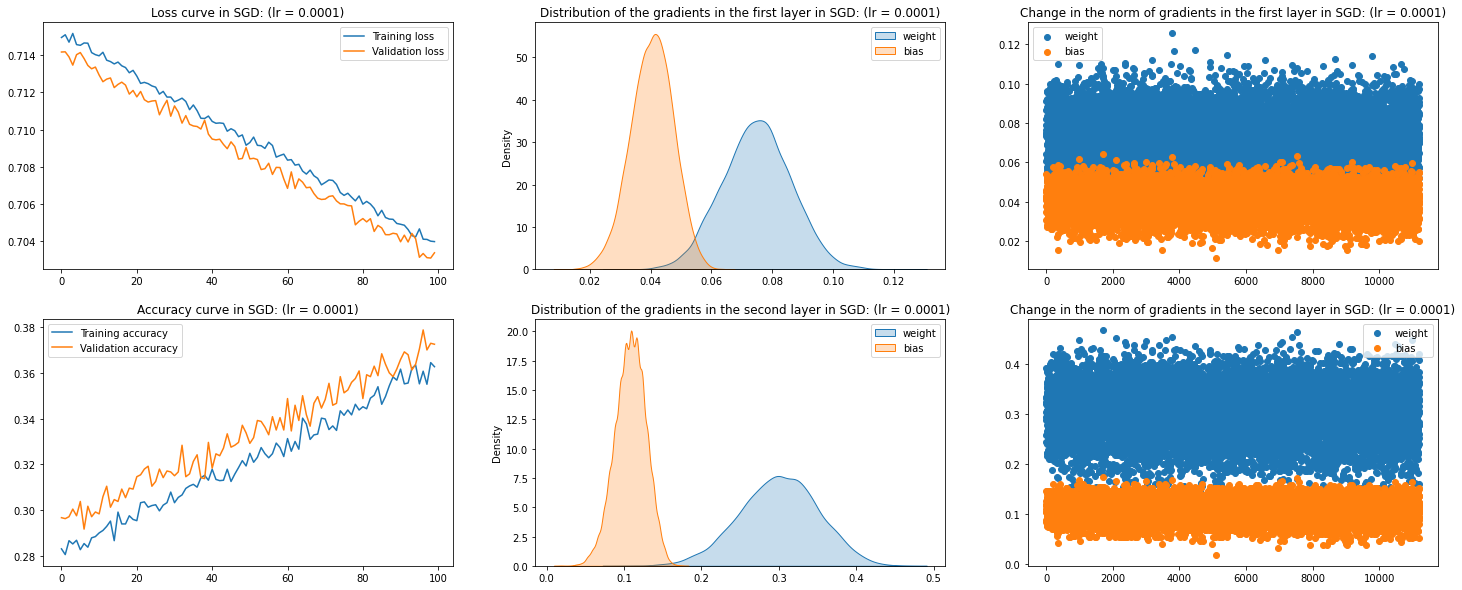

In [ ]:
plotEverything(output_sgd_low,'SGD','0.0001')

In [ ]:
output_sgd_mod = train_network(learning_rate = mod_lr)


Epoch: 1 	Training Loss: 0.6876 	Training Accuracy: 0.5930 	Validation Loss: 0.6833 	Validation Accuracy: 0.6150

Epoch: 2 	Training Loss: 0.6793 	Training Accuracy: 0.6330 	Validation Loss: 0.6757 	Validation Accuracy: 0.6425

Epoch: 3 	Training Loss: 0.6712 	Training Accuracy: 0.6779 	Validation Loss: 0.6680 	Validation Accuracy: 0.7004

Epoch: 4 	Training Loss: 0.6639 	Training Accuracy: 0.7280 	Validation Loss: 0.6610 	Validation Accuracy: 0.7546

Epoch: 5 	Training Loss: 0.6568 	Training Accuracy: 0.7789 	Validation Loss: 0.6546 	Validation Accuracy: 0.7837

Epoch: 6 	Training Loss: 0.6501 	Training Accuracy: 0.7925 	Validation Loss: 0.6481 	Validation Accuracy: 0.7896

Epoch: 7 	Training Loss: 0.6439 	Training Accuracy: 0.7959 	Validation Loss: 0.6421 	Validation Accuracy: 0.7892

Epoch: 8 	Training Loss: 0.6377 	Training Accuracy: 0.7959 	Validation Loss: 0.6365 	Validation Accuracy: 0.7896

Epoch: 9 	Training Loss: 0.6322 	Training Accuracy: 0.7961 	Validation Loss: 0.6312 	Va

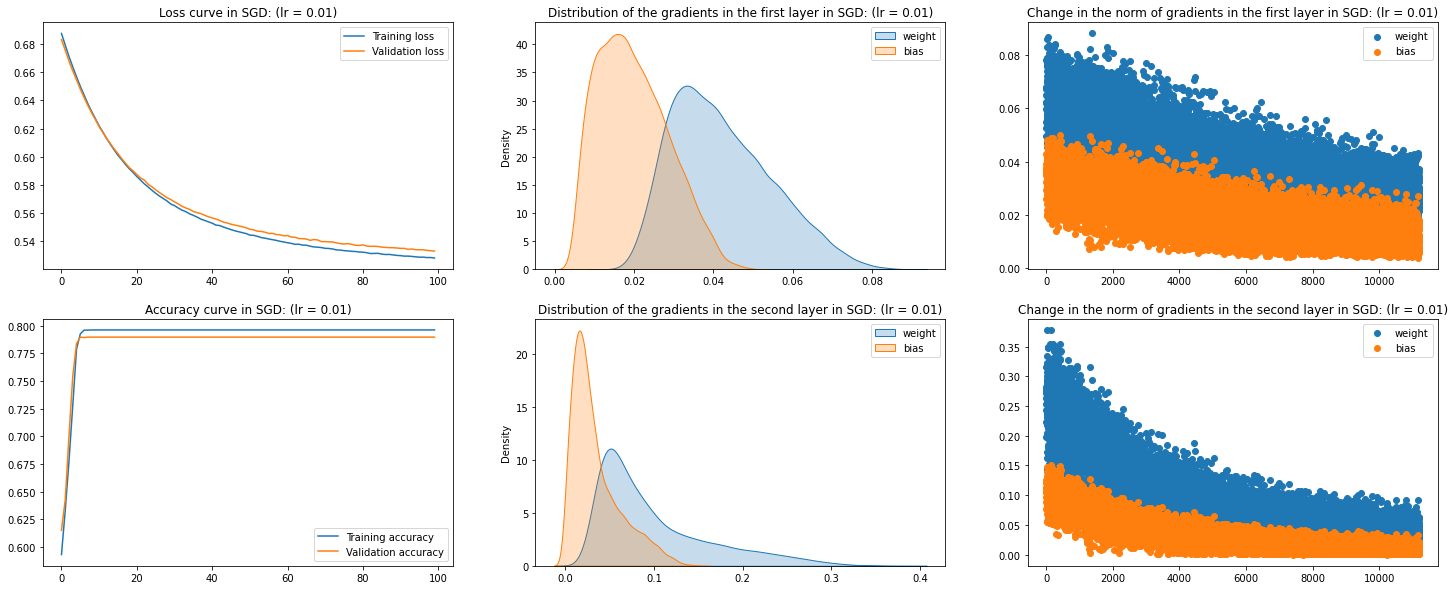

In [ ]:
plotEverything(output_sgd_mod,'SGD','0.01')

In [ ]:
output_sgd_high = train_network(learning_rate = high_lr)


Epoch: 1 	Training Loss: 0.5616 	Training Accuracy: 0.7904 	Validation Loss: 0.5333 	Validation Accuracy: 0.7896

Epoch: 2 	Training Loss: 0.5234 	Training Accuracy: 0.7961 	Validation Loss: 0.5262 	Validation Accuracy: 0.7896

Epoch: 3 	Training Loss: 0.5190 	Training Accuracy: 0.7961 	Validation Loss: 0.5238 	Validation Accuracy: 0.7896

Epoch: 4 	Training Loss: 0.5170 	Training Accuracy: 0.7961 	Validation Loss: 0.5223 	Validation Accuracy: 0.7896

Epoch: 5 	Training Loss: 0.5159 	Training Accuracy: 0.7961 	Validation Loss: 0.5211 	Validation Accuracy: 0.7896

Epoch: 6 	Training Loss: 0.5149 	Training Accuracy: 0.7961 	Validation Loss: 0.5207 	Validation Accuracy: 0.7896

Epoch: 7 	Training Loss: 0.5141 	Training Accuracy: 0.7961 	Validation Loss: 0.5201 	Validation Accuracy: 0.7896

Epoch: 8 	Training Loss: 0.5136 	Training Accuracy: 0.7961 	Validation Loss: 0.5191 	Validation Accuracy: 0.7896

Epoch: 9 	Training Loss: 0.5129 	Training Accuracy: 0.7961 	Validation Loss: 0.5184 	Va

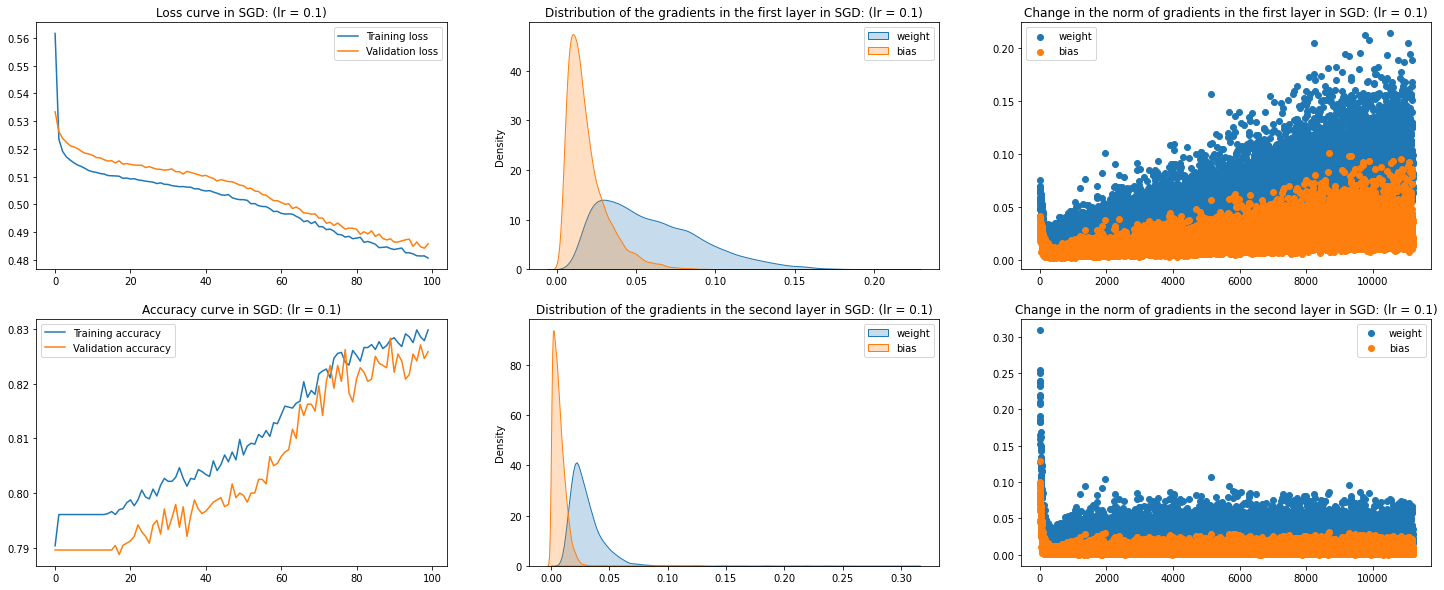

In [ ]:
plotEverything(output_sgd_high,'SGD','0.1')

ii) SGD with momentum

If there is a long shallow ravine with steep walls on the direction to the optimal point, then the standard SGD will tend to oscillate across the narrow ravine. Momentum is one of the mechanism which is used to fix the direction:
$$v_{k} = mv_{k−1} + t_{k}∆f(x_{k}) ;\;\;\; x_{k+1} = x_{k} − v_{k}$$

where m ∈ (0, 1] determines for how many iterations the previous gradients are incorporated into the current update. Generally m is set to 0.5 until the initial learning stabilizes and then is increased to 0.9 or higher.

In [ ]:
output_sgdm_low = train_network('SGD with momentum',low_lr)


Epoch: 1 	Training Loss: 0.6911 	Training Accuracy: 0.5696 	Validation Loss: 0.6911 	Validation Accuracy: 0.5725

Epoch: 2 	Training Loss: 0.6903 	Training Accuracy: 0.5779 	Validation Loss: 0.6897 	Validation Accuracy: 0.5817

Epoch: 3 	Training Loss: 0.6893 	Training Accuracy: 0.5850 	Validation Loss: 0.6892 	Validation Accuracy: 0.5817

Epoch: 4 	Training Loss: 0.6886 	Training Accuracy: 0.5825 	Validation Loss: 0.6884 	Validation Accuracy: 0.5921

Epoch: 5 	Training Loss: 0.6876 	Training Accuracy: 0.5948 	Validation Loss: 0.6878 	Validation Accuracy: 0.5913

Epoch: 6 	Training Loss: 0.6870 	Training Accuracy: 0.5996 	Validation Loss: 0.6869 	Validation Accuracy: 0.5929

Epoch: 7 	Training Loss: 0.6862 	Training Accuracy: 0.5995 	Validation Loss: 0.6856 	Validation Accuracy: 0.5946

Epoch: 8 	Training Loss: 0.6852 	Training Accuracy: 0.6062 	Validation Loss: 0.6850 	Validation Accuracy: 0.6004

Epoch: 9 	Training Loss: 0.6843 	Training Accuracy: 0.6068 	Validation Loss: 0.6839 	Va

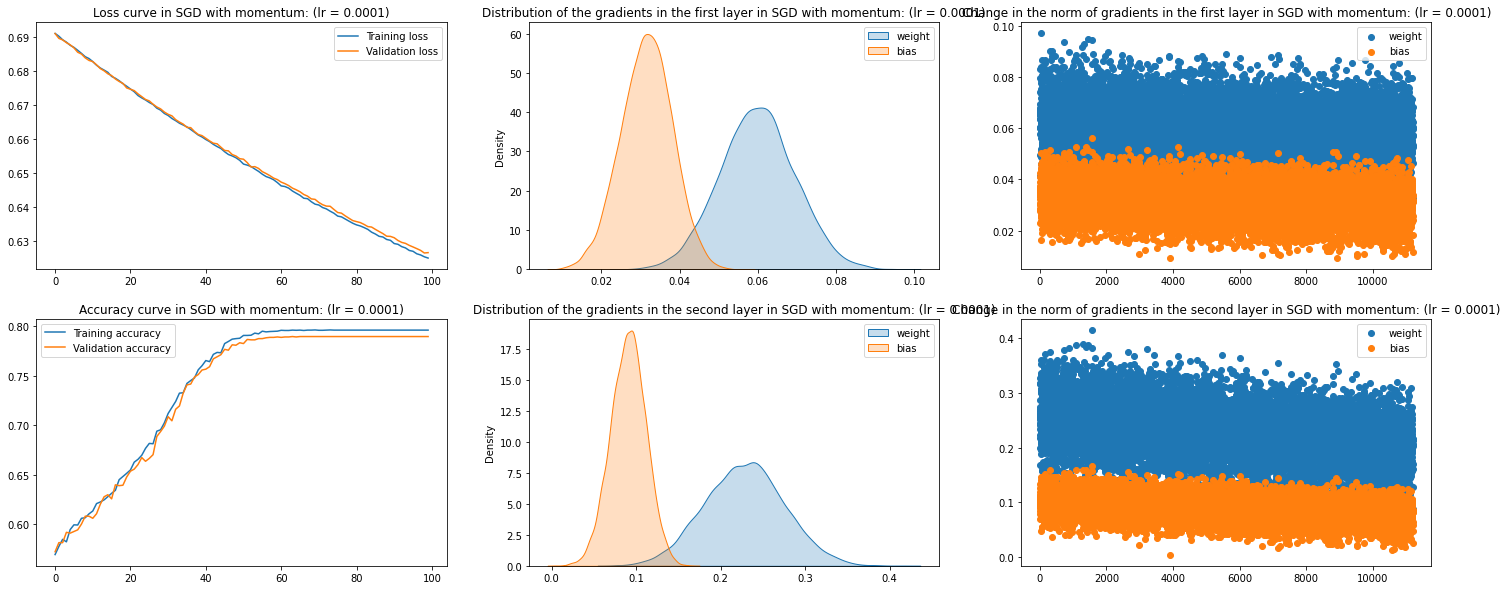

In [ ]:
plotEverything(output_sgdm_low,'SGD with momentum','0.0001')

In [ ]:
output_sgdm_mod = train_network('SGD with momentum')


Epoch: 1 	Training Loss: 0.6597 	Training Accuracy: 0.7170 	Validation Loss: 0.6292 	Validation Accuracy: 0.7896

Epoch: 2 	Training Loss: 0.6059 	Training Accuracy: 0.7961 	Validation Loss: 0.5912 	Validation Accuracy: 0.7896

Epoch: 3 	Training Loss: 0.5766 	Training Accuracy: 0.7961 	Validation Loss: 0.5701 	Validation Accuracy: 0.7896

Epoch: 4 	Training Loss: 0.5595 	Training Accuracy: 0.7961 	Validation Loss: 0.5576 	Validation Accuracy: 0.7896

Epoch: 5 	Training Loss: 0.5486 	Training Accuracy: 0.7961 	Validation Loss: 0.5495 	Validation Accuracy: 0.7896

Epoch: 6 	Training Loss: 0.5419 	Training Accuracy: 0.7961 	Validation Loss: 0.5444 	Validation Accuracy: 0.7896

Epoch: 7 	Training Loss: 0.5373 	Training Accuracy: 0.7961 	Validation Loss: 0.5400 	Validation Accuracy: 0.7896

Epoch: 8 	Training Loss: 0.5337 	Training Accuracy: 0.7961 	Validation Loss: 0.5369 	Validation Accuracy: 0.7896

Epoch: 9 	Training Loss: 0.5310 	Training Accuracy: 0.7961 	Validation Loss: 0.5353 	Va

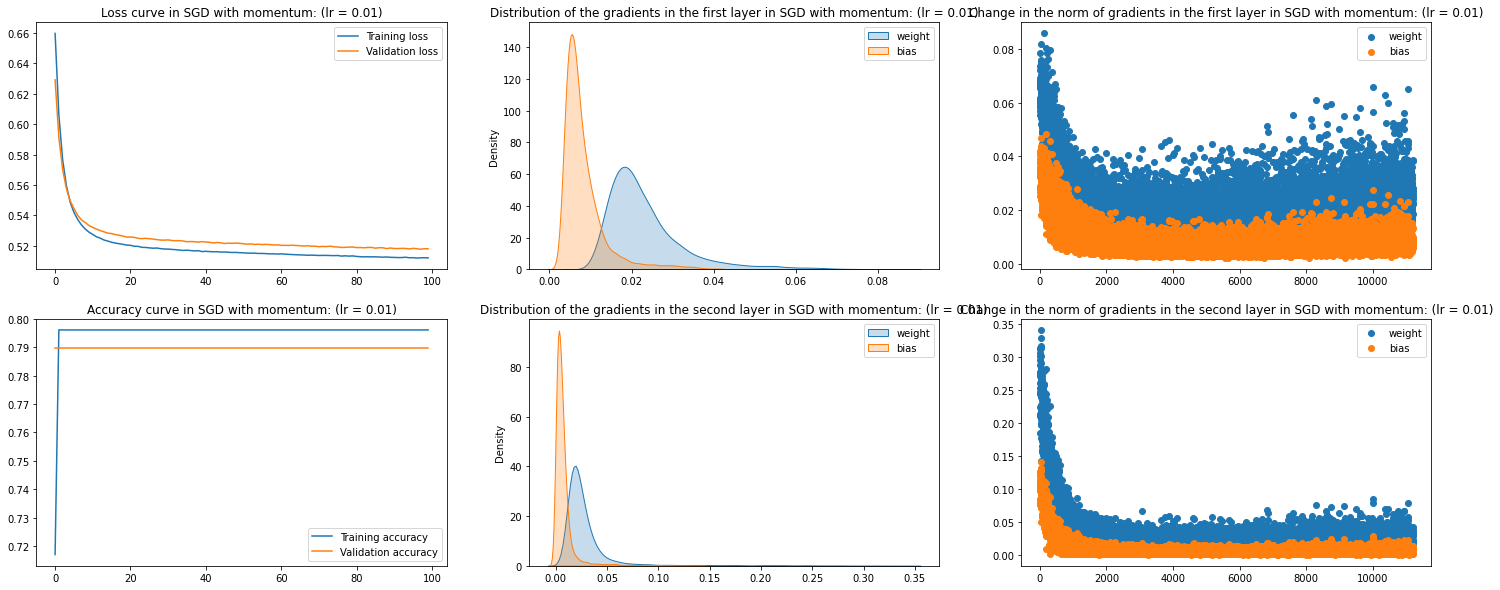

In [ ]:
plotEverything(output_sgdm_mod,'SGD with momentum','0.01')

In [ ]:
output_sgdm_high = train_network('SGD with momentum',high_lr)


Epoch: 1 	Training Loss: 0.5279 	Training Accuracy: 0.7916 	Validation Loss: 0.5222 	Validation Accuracy: 0.7896

Epoch: 2 	Training Loss: 0.5133 	Training Accuracy: 0.7961 	Validation Loss: 0.5166 	Validation Accuracy: 0.7896

Epoch: 3 	Training Loss: 0.5105 	Training Accuracy: 0.7968 	Validation Loss: 0.5147 	Validation Accuracy: 0.7904

Epoch: 4 	Training Loss: 0.5088 	Training Accuracy: 0.7984 	Validation Loss: 0.5134 	Validation Accuracy: 0.7908

Epoch: 5 	Training Loss: 0.5075 	Training Accuracy: 0.8005 	Validation Loss: 0.5111 	Validation Accuracy: 0.7963

Epoch: 6 	Training Loss: 0.5060 	Training Accuracy: 0.8007 	Validation Loss: 0.5101 	Validation Accuracy: 0.7950

Epoch: 7 	Training Loss: 0.5024 	Training Accuracy: 0.8030 	Validation Loss: 0.5045 	Validation Accuracy: 0.7996

Epoch: 8 	Training Loss: 0.4979 	Training Accuracy: 0.8132 	Validation Loss: 0.5013 	Validation Accuracy: 0.8050

Epoch: 9 	Training Loss: 0.4945 	Training Accuracy: 0.8148 	Validation Loss: 0.4953 	Va

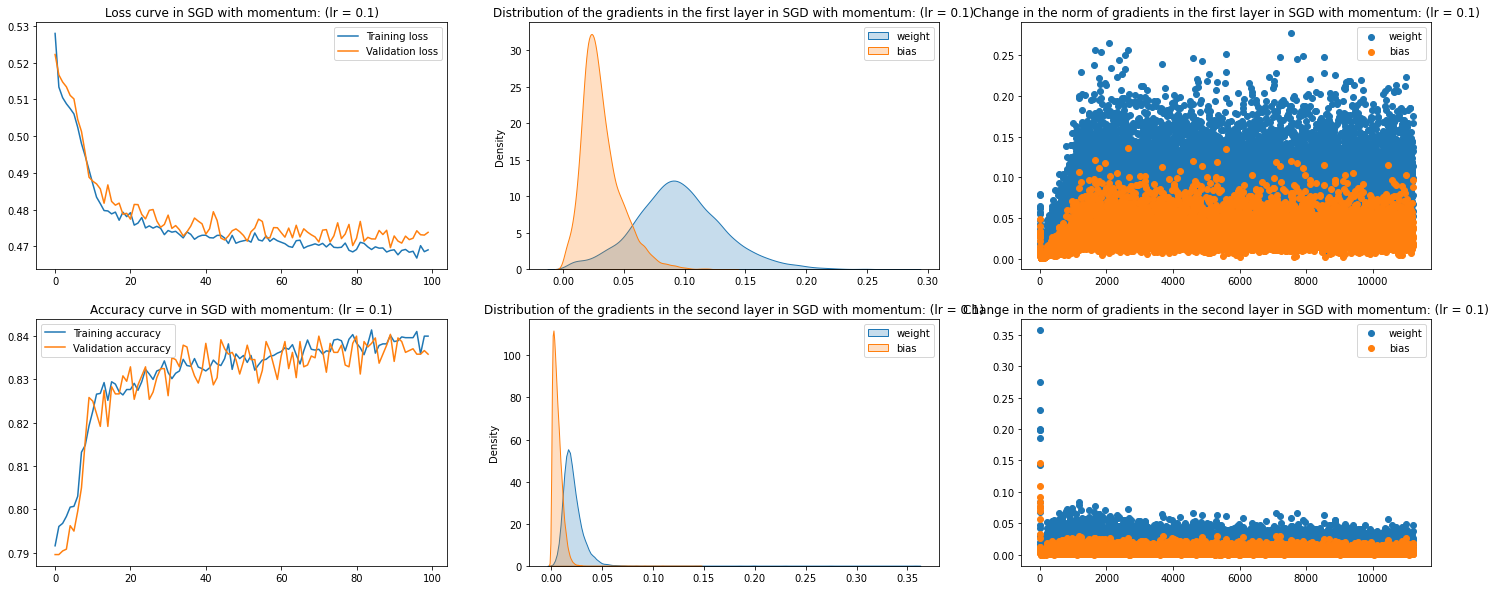

In [ ]:
plotEverything(output_sgdm_high,'SGD with momentum','0.1')

iii) Adagrad

In [ ]:
output_adgd_low = train_network('Adagrad',low_lr)


Epoch: 1 	Training Loss: 0.6910 	Training Accuracy: 0.5727 	Validation Loss: 0.6904 	Validation Accuracy: 0.5792

Epoch: 2 	Training Loss: 0.6905 	Training Accuracy: 0.5791 	Validation Loss: 0.6901 	Validation Accuracy: 0.5792

Epoch: 3 	Training Loss: 0.6899 	Training Accuracy: 0.5845 	Validation Loss: 0.6900 	Validation Accuracy: 0.5746

Epoch: 4 	Training Loss: 0.6898 	Training Accuracy: 0.5809 	Validation Loss: 0.6896 	Validation Accuracy: 0.5746

Epoch: 5 	Training Loss: 0.6894 	Training Accuracy: 0.5905 	Validation Loss: 0.6894 	Validation Accuracy: 0.5775

Epoch: 6 	Training Loss: 0.6894 	Training Accuracy: 0.5829 	Validation Loss: 0.6888 	Validation Accuracy: 0.5854

Epoch: 7 	Training Loss: 0.6889 	Training Accuracy: 0.5930 	Validation Loss: 0.6886 	Validation Accuracy: 0.5904

Epoch: 8 	Training Loss: 0.6889 	Training Accuracy: 0.5868 	Validation Loss: 0.6889 	Validation Accuracy: 0.5871

Epoch: 9 	Training Loss: 0.6886 	Training Accuracy: 0.5882 	Validation Loss: 0.6884 	Va

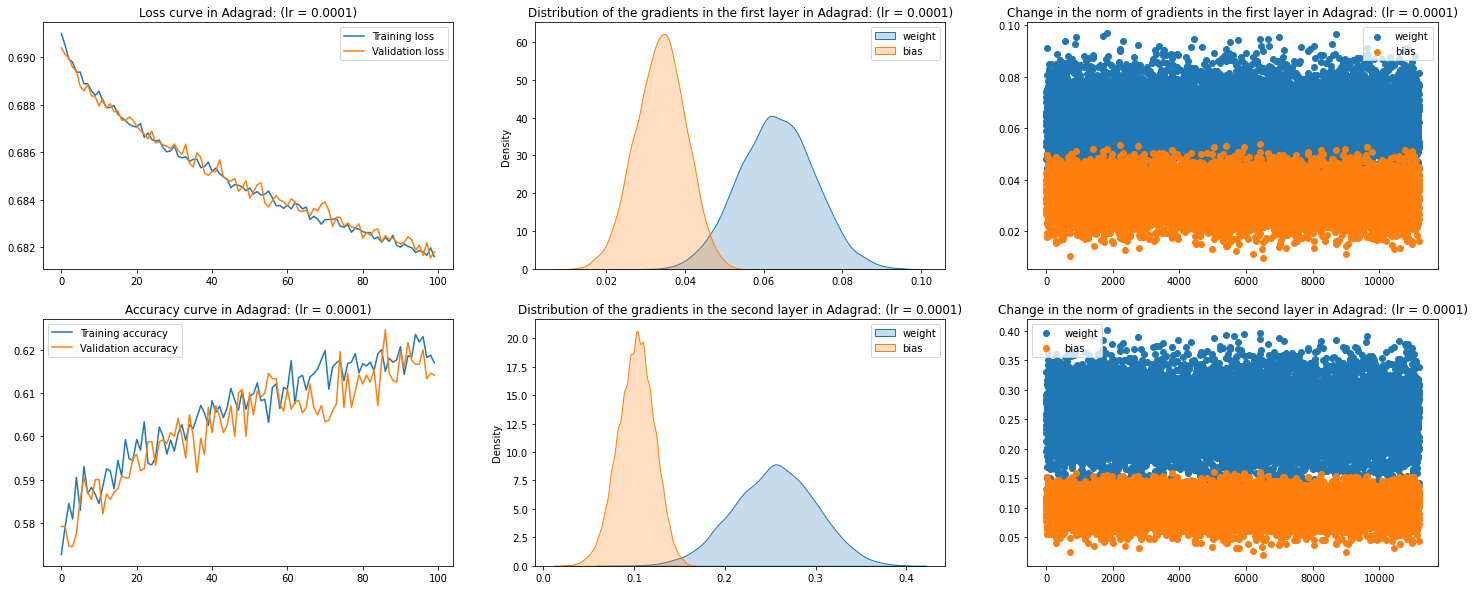

In [ ]:
plotEverything(output_adgd_low,'Adagrad','0.0001')

In [ ]:
output_adgd_mod = train_network('Adagrad')


Epoch: 1 	Training Loss: 0.6390 	Training Accuracy: 0.7739 	Validation Loss: 0.6137 	Validation Accuracy: 0.7896

Epoch: 2 	Training Loss: 0.5962 	Training Accuracy: 0.7961 	Validation Loss: 0.5869 	Validation Accuracy: 0.7896

Epoch: 3 	Training Loss: 0.5746 	Training Accuracy: 0.7961 	Validation Loss: 0.5705 	Validation Accuracy: 0.7896

Epoch: 4 	Training Loss: 0.5616 	Training Accuracy: 0.7961 	Validation Loss: 0.5603 	Validation Accuracy: 0.7896

Epoch: 5 	Training Loss: 0.5521 	Training Accuracy: 0.7961 	Validation Loss: 0.5525 	Validation Accuracy: 0.7896

Epoch: 6 	Training Loss: 0.5459 	Training Accuracy: 0.7961 	Validation Loss: 0.5477 	Validation Accuracy: 0.7896

Epoch: 7 	Training Loss: 0.5407 	Training Accuracy: 0.7961 	Validation Loss: 0.5434 	Validation Accuracy: 0.7896

Epoch: 8 	Training Loss: 0.5370 	Training Accuracy: 0.7961 	Validation Loss: 0.5405 	Validation Accuracy: 0.7896

Epoch: 9 	Training Loss: 0.5340 	Training Accuracy: 0.7961 	Validation Loss: 0.5380 	Va

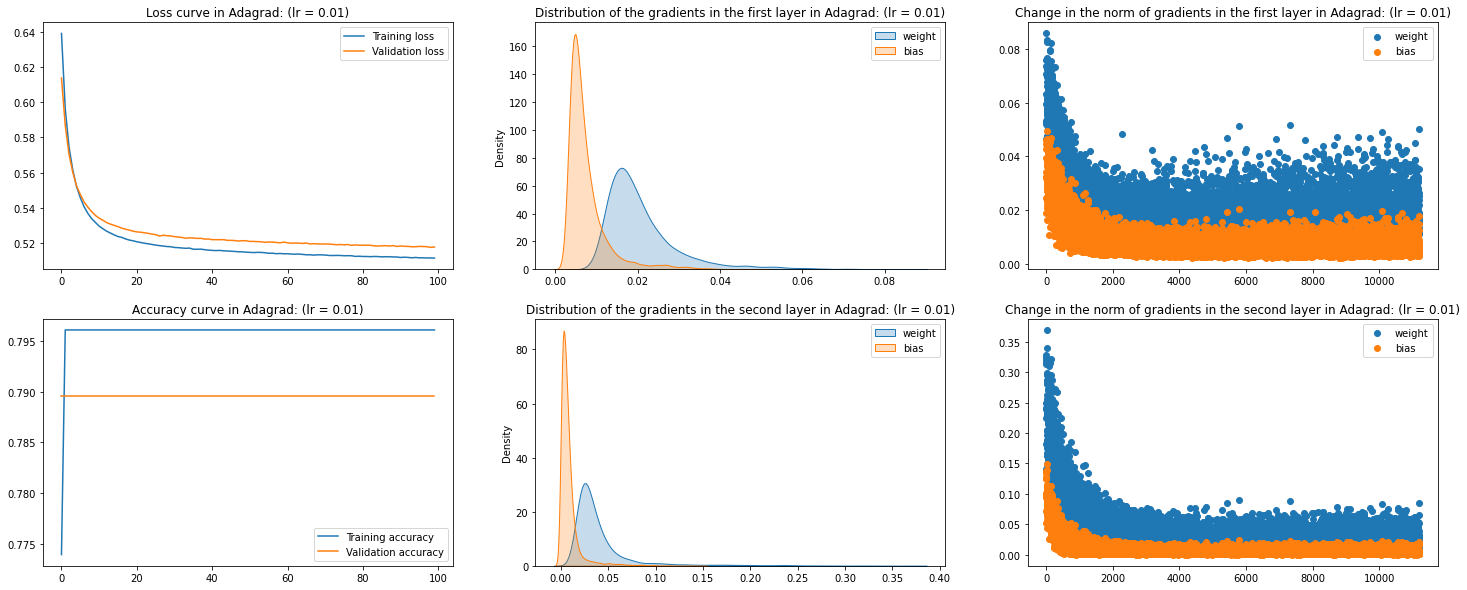

In [ ]:
plotEverything(output_adgd_mod,'Adagrad','0.01')

In [ ]:
output_adgd_high = train_network('Adagrad',high_lr)


Epoch: 1 	Training Loss: 0.5099 	Training Accuracy: 0.7941 	Validation Loss: 0.5057 	Validation Accuracy: 0.7946

Epoch: 2 	Training Loss: 0.4949 	Training Accuracy: 0.8123 	Validation Loss: 0.4917 	Validation Accuracy: 0.8233

Epoch: 3 	Training Loss: 0.4861 	Training Accuracy: 0.8223 	Validation Loss: 0.4868 	Validation Accuracy: 0.8229

Epoch: 4 	Training Loss: 0.4816 	Training Accuracy: 0.8248 	Validation Loss: 0.4837 	Validation Accuracy: 0.8263

Epoch: 5 	Training Loss: 0.4796 	Training Accuracy: 0.8284 	Validation Loss: 0.4843 	Validation Accuracy: 0.8233

Epoch: 6 	Training Loss: 0.4781 	Training Accuracy: 0.8295 	Validation Loss: 0.4824 	Validation Accuracy: 0.8242

Epoch: 7 	Training Loss: 0.4743 	Training Accuracy: 0.8368 	Validation Loss: 0.4812 	Validation Accuracy: 0.8287

Epoch: 8 	Training Loss: 0.4749 	Training Accuracy: 0.8334 	Validation Loss: 0.4809 	Validation Accuracy: 0.8237

Epoch: 9 	Training Loss: 0.4742 	Training Accuracy: 0.8311 	Validation Loss: 0.4784 	Va

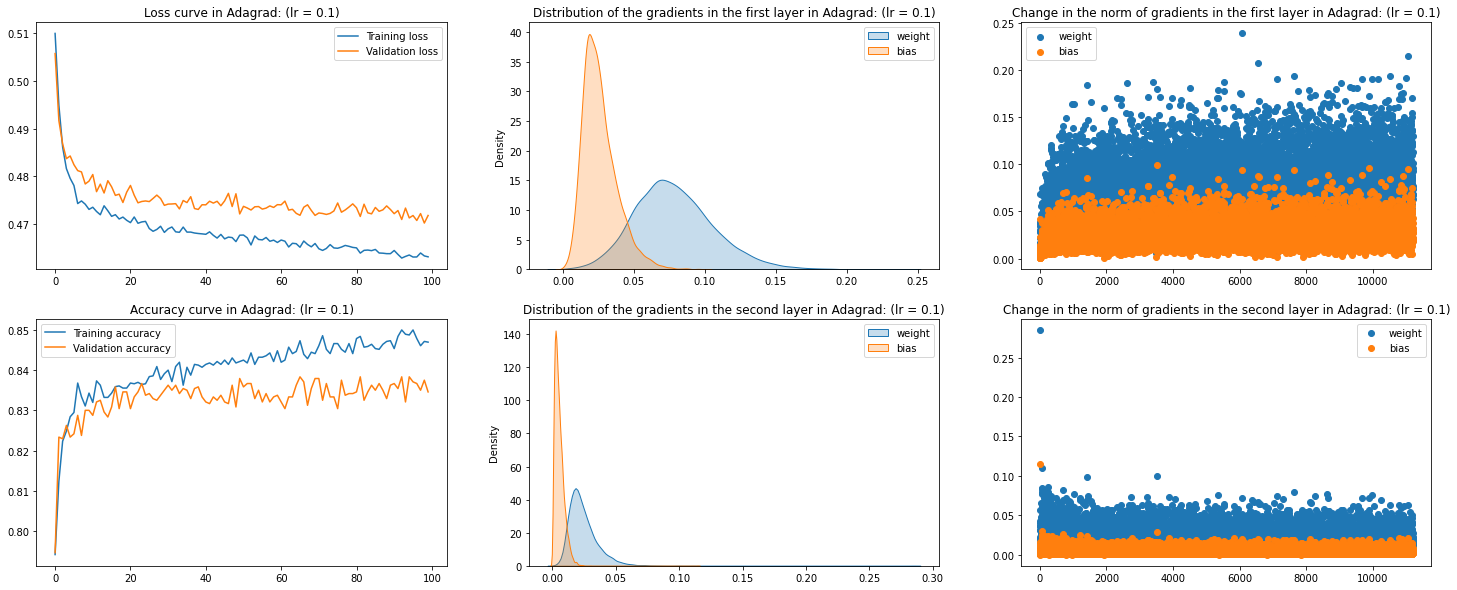

In [ ]:
plotEverything(output_adgd_high,'Adagrad','0.1')

iv) RMSprop

In [ ]:
output_rms_low = train_network('RMSprop', low_lr)


Epoch: 1 	Training Loss: 0.6854 	Training Accuracy: 0.6041 	Validation Loss: 0.6813 	Validation Accuracy: 0.6142

Epoch: 2 	Training Loss: 0.6784 	Training Accuracy: 0.6377 	Validation Loss: 0.6759 	Validation Accuracy: 0.6462

Epoch: 3 	Training Loss: 0.6730 	Training Accuracy: 0.6670 	Validation Loss: 0.6704 	Validation Accuracy: 0.6854

Epoch: 4 	Training Loss: 0.6682 	Training Accuracy: 0.7004 	Validation Loss: 0.6663 	Validation Accuracy: 0.7100

Epoch: 5 	Training Loss: 0.6630 	Training Accuracy: 0.7414 	Validation Loss: 0.6616 	Validation Accuracy: 0.7512

Epoch: 6 	Training Loss: 0.6584 	Training Accuracy: 0.7691 	Validation Loss: 0.6570 	Validation Accuracy: 0.7758

Epoch: 7 	Training Loss: 0.6531 	Training Accuracy: 0.7863 	Validation Loss: 0.6522 	Validation Accuracy: 0.7842

Epoch: 8 	Training Loss: 0.6486 	Training Accuracy: 0.7948 	Validation Loss: 0.6473 	Validation Accuracy: 0.7892

Epoch: 9 	Training Loss: 0.6441 	Training Accuracy: 0.7955 	Validation Loss: 0.6429 	Va

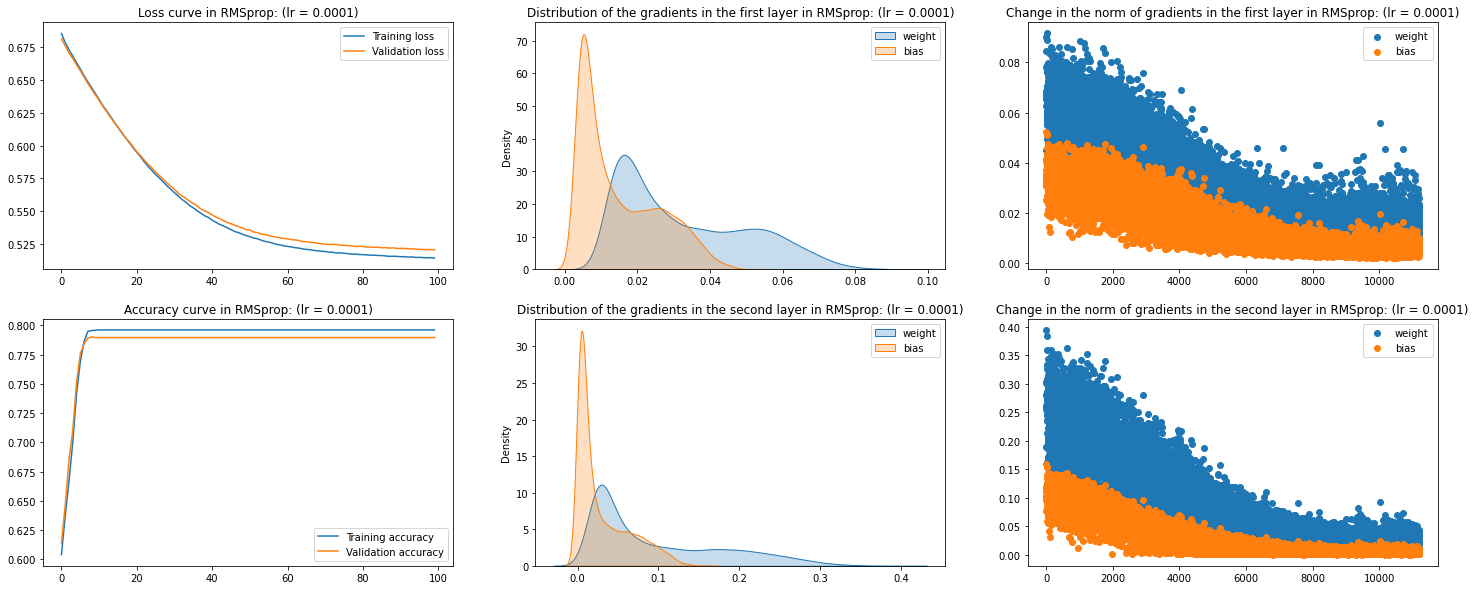

In [ ]:
plotEverything(output_rms_low,'RMSprop','0.0001')

In [ ]:
output_rms_mod = train_network('Adagrad')


Epoch: 1 	Training Loss: 0.6361 	Training Accuracy: 0.7770 	Validation Loss: 0.6105 	Validation Accuracy: 0.7896

Epoch: 2 	Training Loss: 0.5938 	Training Accuracy: 0.7961 	Validation Loss: 0.5846 	Validation Accuracy: 0.7896

Epoch: 3 	Training Loss: 0.5728 	Training Accuracy: 0.7961 	Validation Loss: 0.5691 	Validation Accuracy: 0.7896

Epoch: 4 	Training Loss: 0.5598 	Training Accuracy: 0.7961 	Validation Loss: 0.5586 	Validation Accuracy: 0.7896

Epoch: 5 	Training Loss: 0.5508 	Training Accuracy: 0.7961 	Validation Loss: 0.5521 	Validation Accuracy: 0.7896

Epoch: 6 	Training Loss: 0.5445 	Training Accuracy: 0.7961 	Validation Loss: 0.5464 	Validation Accuracy: 0.7896

Epoch: 7 	Training Loss: 0.5400 	Training Accuracy: 0.7961 	Validation Loss: 0.5428 	Validation Accuracy: 0.7896

Epoch: 8 	Training Loss: 0.5361 	Training Accuracy: 0.7961 	Validation Loss: 0.5399 	Validation Accuracy: 0.7896

Epoch: 9 	Training Loss: 0.5335 	Training Accuracy: 0.7961 	Validation Loss: 0.5377 	Va

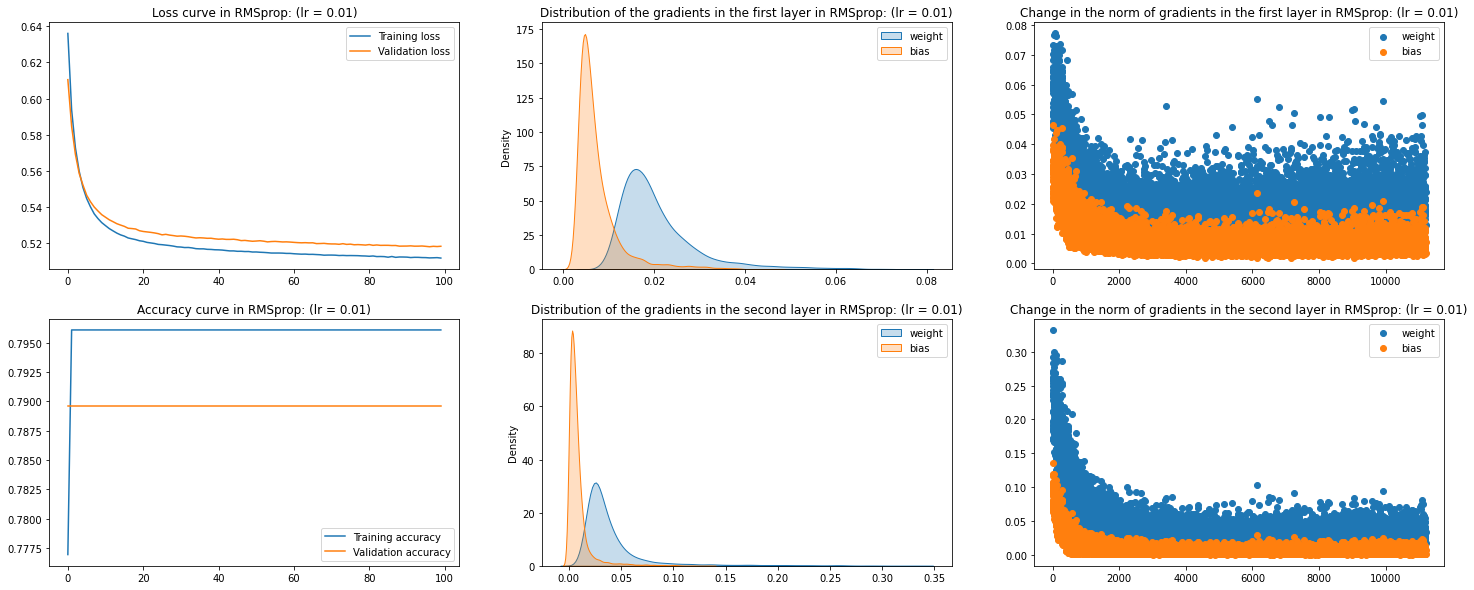

In [ ]:
plotEverything(output_rms_mod,'RMSprop','0.01')

In [ ]:
output_rms_high = train_network('Adagrad',high_lr)


Epoch: 1 	Training Loss: 0.5086 	Training Accuracy: 0.7961 	Validation Loss: 0.5003 	Validation Accuracy: 0.8029

Epoch: 2 	Training Loss: 0.4907 	Training Accuracy: 0.8164 	Validation Loss: 0.4878 	Validation Accuracy: 0.8167

Epoch: 3 	Training Loss: 0.4829 	Training Accuracy: 0.8254 	Validation Loss: 0.4844 	Validation Accuracy: 0.8217

Epoch: 4 	Training Loss: 0.4796 	Training Accuracy: 0.8271 	Validation Loss: 0.4821 	Validation Accuracy: 0.8296

Epoch: 5 	Training Loss: 0.4771 	Training Accuracy: 0.8307 	Validation Loss: 0.4798 	Validation Accuracy: 0.8313

Epoch: 6 	Training Loss: 0.4754 	Training Accuracy: 0.8293 	Validation Loss: 0.4767 	Validation Accuracy: 0.8313

Epoch: 7 	Training Loss: 0.4749 	Training Accuracy: 0.8309 	Validation Loss: 0.4790 	Validation Accuracy: 0.8263

Epoch: 8 	Training Loss: 0.4744 	Training Accuracy: 0.8316 	Validation Loss: 0.4758 	Validation Accuracy: 0.8308

Epoch: 9 	Training Loss: 0.4736 	Training Accuracy: 0.8330 	Validation Loss: 0.4768 	Va

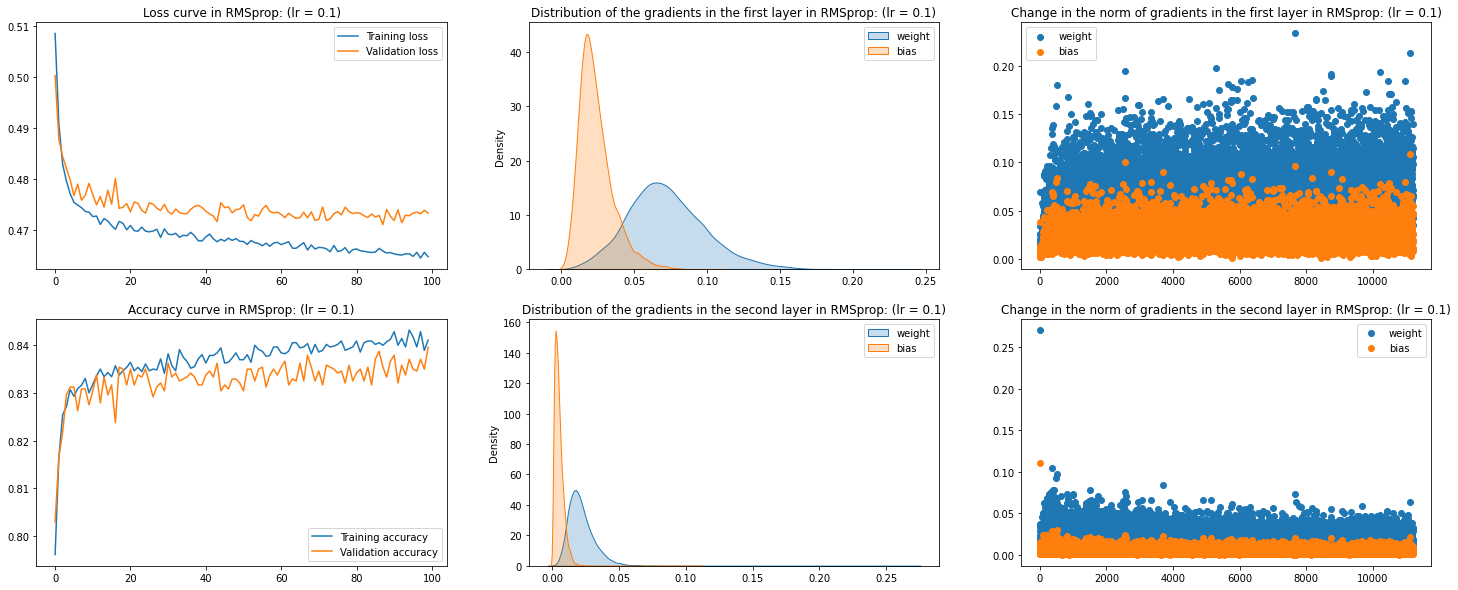

In [ ]:
plotEverything(output_rms_high,'RMSprop','0.1')

In [ ]:
output_adam_low = train_network('Adam',low_lr)


Epoch: 1 	Training Loss: 0.6889 	Training Accuracy: 0.5886 	Validation Loss: 0.6865 	Validation Accuracy: 0.5971

Epoch: 2 	Training Loss: 0.6836 	Training Accuracy: 0.6120 	Validation Loss: 0.6815 	Validation Accuracy: 0.6188

Epoch: 3 	Training Loss: 0.6786 	Training Accuracy: 0.6380 	Validation Loss: 0.6762 	Validation Accuracy: 0.6429

Epoch: 4 	Training Loss: 0.6738 	Training Accuracy: 0.6607 	Validation Loss: 0.6717 	Validation Accuracy: 0.6713

Epoch: 5 	Training Loss: 0.6687 	Training Accuracy: 0.6971 	Validation Loss: 0.6667 	Validation Accuracy: 0.7150

Epoch: 6 	Training Loss: 0.6638 	Training Accuracy: 0.7338 	Validation Loss: 0.6619 	Validation Accuracy: 0.7458

Epoch: 7 	Training Loss: 0.6590 	Training Accuracy: 0.7664 	Validation Loss: 0.6574 	Validation Accuracy: 0.7754

Epoch: 8 	Training Loss: 0.6541 	Training Accuracy: 0.7850 	Validation Loss: 0.6527 	Validation Accuracy: 0.7837

Epoch: 9 	Training Loss: 0.6493 	Training Accuracy: 0.7920 	Validation Loss: 0.6484 	Va

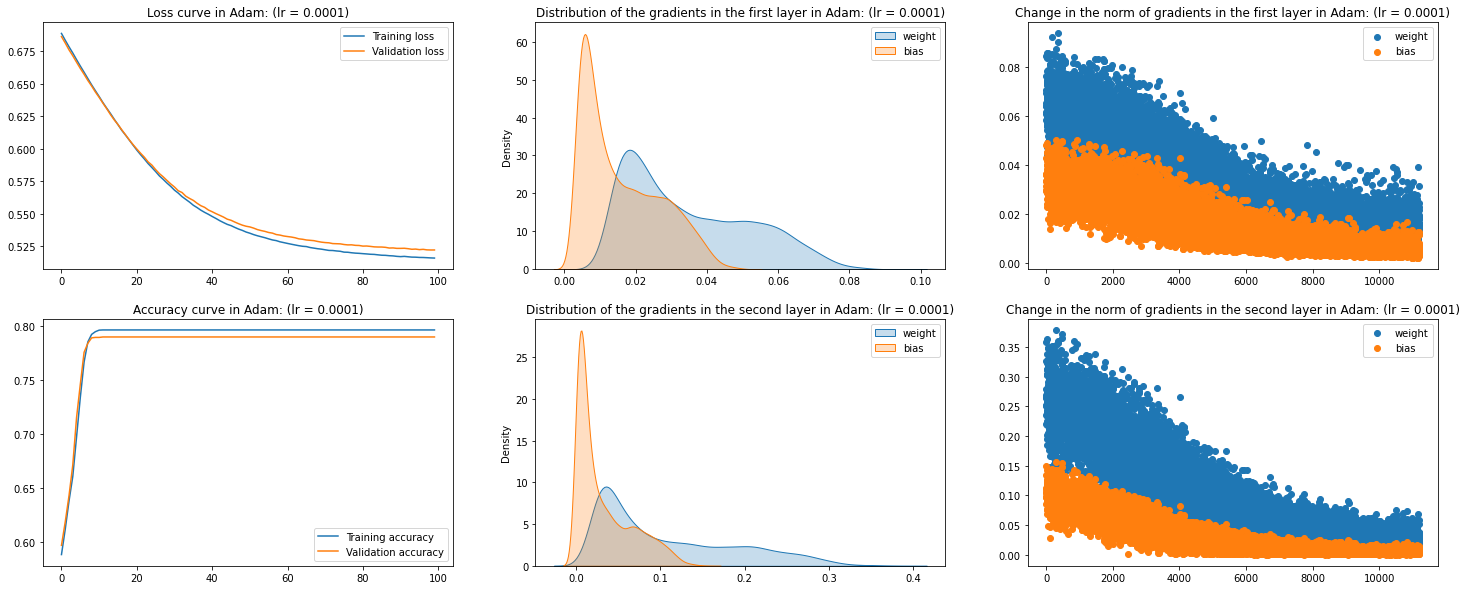

In [ ]:
plotEverything(output_adam_low,'Adam','0.0001')

In [ ]:
output_adam_mod = train_network('Adam')


Epoch: 1 	Training Loss: 0.5610 	Training Accuracy: 0.7864 	Validation Loss: 0.5243 	Validation Accuracy: 0.7896

Epoch: 2 	Training Loss: 0.5151 	Training Accuracy: 0.7961 	Validation Loss: 0.5188 	Validation Accuracy: 0.7896

Epoch: 3 	Training Loss: 0.5107 	Training Accuracy: 0.7964 	Validation Loss: 0.5153 	Validation Accuracy: 0.7904

Epoch: 4 	Training Loss: 0.5083 	Training Accuracy: 0.7980 	Validation Loss: 0.5120 	Validation Accuracy: 0.7946

Epoch: 5 	Training Loss: 0.5058 	Training Accuracy: 0.8020 	Validation Loss: 0.5104 	Validation Accuracy: 0.7937

Epoch: 6 	Training Loss: 0.5035 	Training Accuracy: 0.8037 	Validation Loss: 0.5073 	Validation Accuracy: 0.7983

Epoch: 7 	Training Loss: 0.5003 	Training Accuracy: 0.8095 	Validation Loss: 0.5020 	Validation Accuracy: 0.8013

Epoch: 8 	Training Loss: 0.4964 	Training Accuracy: 0.8105 	Validation Loss: 0.4983 	Validation Accuracy: 0.8129

Epoch: 9 	Training Loss: 0.4926 	Training Accuracy: 0.8177 	Validation Loss: 0.4944 	Va

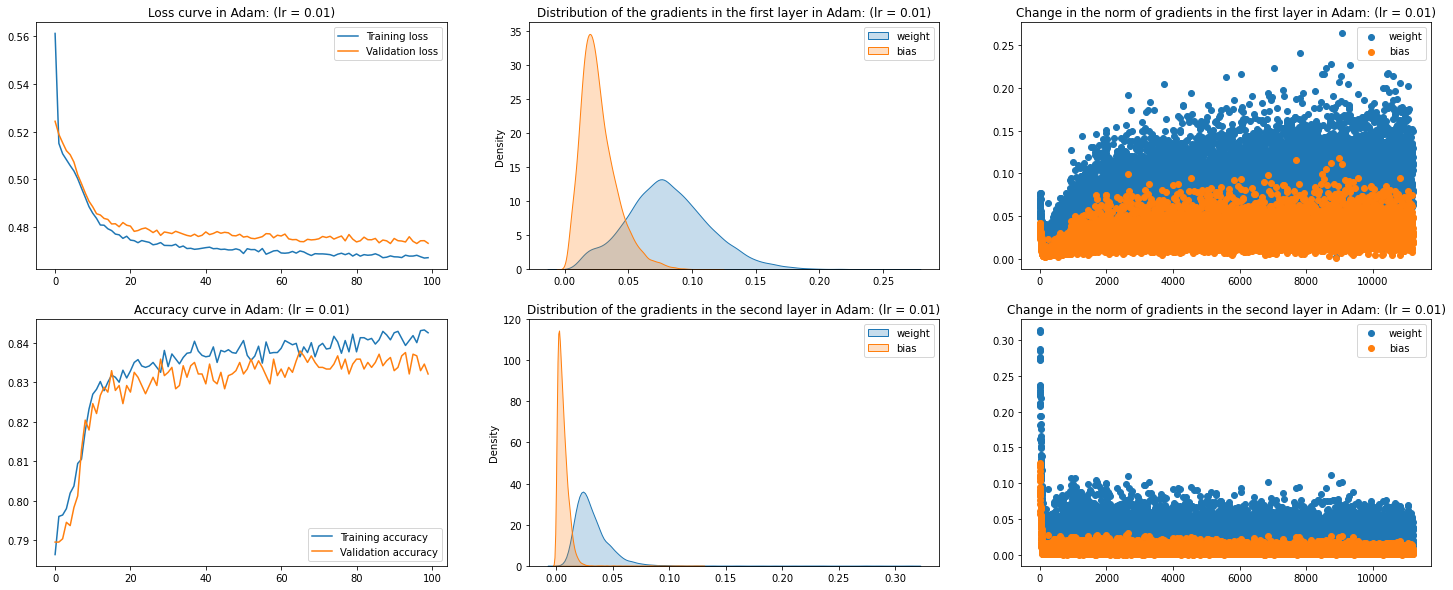

In [ ]:
plotEverything(output_adam_mod,'Adam','0.01')

In [ ]:
output_adam_high = train_network('Adam', high_lr)


Epoch: 1 	Training Loss: 0.5190 	Training Accuracy: 0.7927 	Validation Loss: 0.5237 	Validation Accuracy: 0.7896

Epoch: 2 	Training Loss: 0.5172 	Training Accuracy: 0.7961 	Validation Loss: 0.5237 	Validation Accuracy: 0.7896

Epoch: 3 	Training Loss: 0.5172 	Training Accuracy: 0.7961 	Validation Loss: 0.5237 	Validation Accuracy: 0.7896

Epoch: 4 	Training Loss: 0.5172 	Training Accuracy: 0.7961 	Validation Loss: 0.5237 	Validation Accuracy: 0.7896

Epoch: 5 	Training Loss: 0.5172 	Training Accuracy: 0.7961 	Validation Loss: 0.5237 	Validation Accuracy: 0.7896

Epoch: 6 	Training Loss: 0.5172 	Training Accuracy: 0.7961 	Validation Loss: 0.5237 	Validation Accuracy: 0.7896

Epoch: 7 	Training Loss: 0.5172 	Training Accuracy: 0.7961 	Validation Loss: 0.5237 	Validation Accuracy: 0.7896

Epoch: 8 	Training Loss: 0.5172 	Training Accuracy: 0.7961 	Validation Loss: 0.5237 	Validation Accuracy: 0.7896

Epoch: 9 	Training Loss: 0.5172 	Training Accuracy: 0.7961 	Validation Loss: 0.5237 	Va

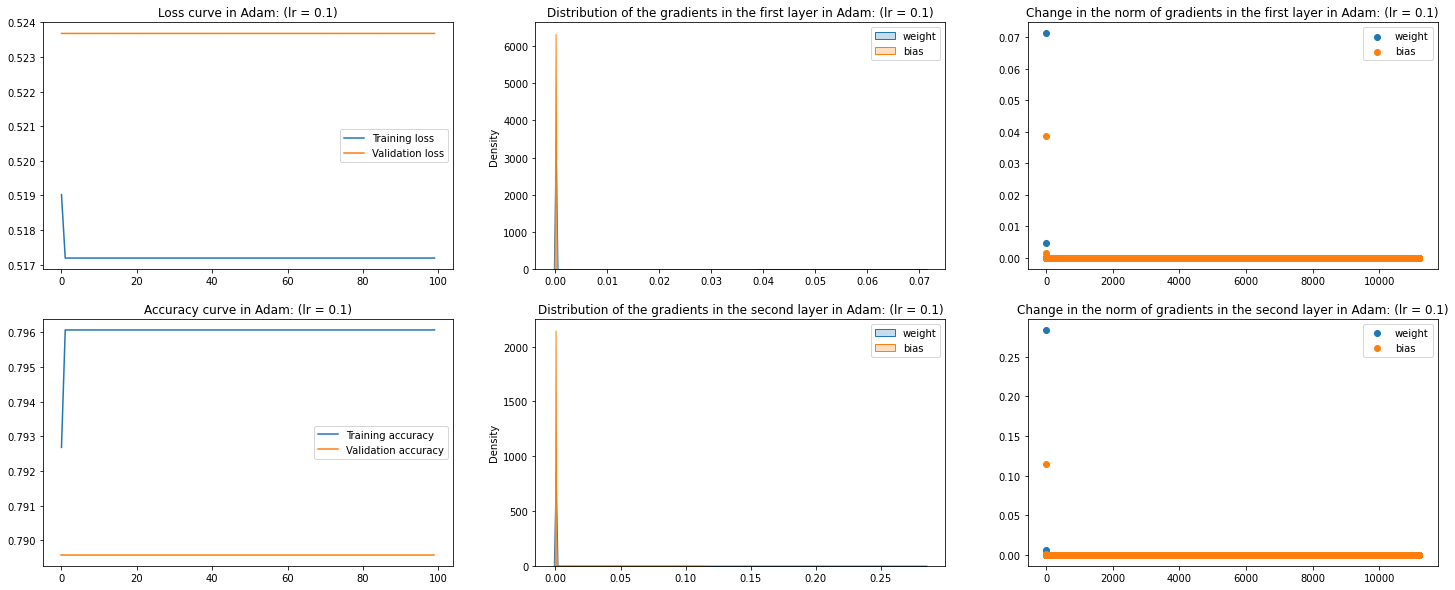

In [ ]:
plotEverything(output_adam_high,'Adam','0.1')

In [ ]:
Optimizers = ['SGD','SGD with momentum','Adagrad','RMSprop','Adam']
Training_Loss = [0.6835,0.6263,0.6804,0.4898,0.5204]
Training_Accuracy = [0.6102,0.7946,0.6955,0.8212,0.7923]
Test_Loss = [0.6826,0.6265,0.6806,0.4858,0.5139]
Test_Accuracy = [0.6250,0.7929,0.6875,0.8287,0.7983]

dict = {'Optimizers' : Optimizers, 'Training_Loss' : Training_Loss, 'Training_Accuracy' : Training_Accuracy, 'Test_Loss' : Test_Loss, 'Test_Accuracy' : Test_Accuracy}
low = pd.DataFrame(dict)

print('Loss-accuracy for low learning rate (0.0001):')
low

Loss-accuracy for low learning rate (0.0001):


,Optimizers,Training_Loss,Training_Accuracy,Test_Loss,Test_Accuracy
0,SGD,0.6835,0.6102,0.6826,0.6250
1,SGD with momentum,0.6263,0.7946,0.6265,0.7929
2,Adagrad,0.6804,0.6955,0.6806,0.6875
3,RMSprop,0.4898,0.8212,0.4858,0.8287
4,Adam,0.5204,0.7923,0.5139,0.7983


In [ ]:
Optimizers = ['SGD','SGD with momentum','Adagrad','RMSprop','Adam']
Training_Loss = [0.5227,0.5148,0.5116,0.4455,0.4732]
Training_Accuracy = [0.8029,0.7946,0.7952,0.8612,0.8380]
Test_Loss = [0.5334,0.5148,0.5155,0.4495,0.4716]
Test_Accuracy = [0.7904,0.7929,0.7925,0.8579,0.8379]

dict = {'Optimizers' : Optimizers, 'Training_Loss' : Training_Loss, 'Training_Accuracy' : Training_Accuracy, 'Test_Loss' : Test_Loss, 'Test_Accuracy' : Test_Accuracy}
mod = pd.DataFrame(dict)

print('Loss-accuracy for moderate learning rate (0.01):')
mod

Loss-accuracy for moderate learning rate (0.01):


,Optimizers,Training_Loss,Training_Accuracy,Test_Loss,Test_Accuracy
0,SGD,0.5227,0.8029,0.5334,0.7904
1,SGD with momentum,0.5148,0.7946,0.5148,0.7929
2,Adagrad,0.5116,0.7952,0.5155,0.7925
3,RMSprop,0.4455,0.8612,0.4495,0.8579
4,Adam,0.4732,0.8380,0.4716,0.8379


In [ ]:
Optimizers = ['SGD','SGD with momentum','Adagrad','RMSprop','Adam']
Training_Loss = [0.6911,0.4653,0.4604,0.5204,0.5172]
Training_Accuracy = [0.5721,0.8414,0.8512,0.7929,0.7961]
Test_Loss = [0.6921,0.4703,0.4862,0.5162,0.5237]
Test_Accuracy = [0.5658,0.8392,0.8217,0.7971,0.7896]

dict = {'Optimizers' : Optimizers, 'Training_Loss' : Training_Loss, 'Training_Accuracy' : Training_Accuracy, 'Test_Loss' : Test_Loss, 'Test_Accuracy' : Test_Accuracy}
high = pd.DataFrame(dict)

print('Loss-accuracy for high learning rate (1.0):')
high

Loss-accuracy for high learning rate (1.0):


,Optimizers,Training_Loss,Training_Accuracy,Test_Loss,Test_Accuracy
0,SGD,0.6911,0.5721,0.6921,0.5658
1,SGD with momentum,0.4653,0.8414,0.4703,0.8392
2,Adagrad,0.4604,0.8512,0.4862,0.8217
3,RMSprop,0.5204,0.7929,0.5162,0.7971
4,Adam,0.5172,0.7961,0.5237,0.7896
